# Machine Translation

English-German Translation

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
import string 
import re 
from numpy import array, argmax, random, take 
import pandas as pd 
import matplotlib.pyplot as plt 
% matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [3]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model 
from keras import optimizers 


Using TensorFlow backend.


# 2)- Reading Dataset

In [0]:
# function to read raw text file
def read_text(filename): 
        # open the file 
        file = open(filename, mode='rt', encoding='utf-8') 
        
        # read all text 
        text = file.read() 
        file.close() 
        return text

In [0]:
# split text into sentences 
def to_lines(text): 
      sents = text.strip().split('\n') 
      sents = [i.split('\t') for i in sents] 
      return sents

In [0]:
data = read_text("deu.txt") 
deu_eng = to_lines(data) 
deu_eng = array(deu_eng)

In [0]:
deu_eng = deu_eng[:50000,:]

# 3)-Text Pre-Processing

In [8]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['The man died of cancer.', 'Der Mann starb an Krebs.'],
       ['The man lay motionless.', 'Der Mann lag bewegungslos da.'],
       ['The man must be insane.', 'Der Mann muss geistesgestört sein.']],
      dtype='<U537')

In [9]:
# for english part 
deu_eng[:,0]

array(['Hi.', 'Hi.', 'Run!', ..., 'The man died of cancer.',
       'The man lay motionless.', 'The man must be insane.'],
      dtype='<U537')

In [10]:
# for german part of lang.
deu_eng[:,1]

array(['Hallo!', 'Grüß Gott!', 'Lauf!', ..., 'Der Mann starb an Krebs.',
       'Der Mann lag bewegungslos da.',
       'Der Mann muss geistesgestört sein.'], dtype='<U537')

### 3.1)-Text cleaning

In [0]:
# Remove punctuation 
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]] 
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]] 

# convert text to lowercase 
for i in range(len(deu_eng)): 
    deu_eng[i,0] = deu_eng[i,0].lower() 
    deu_eng[i,1] = deu_eng[i,1].lower()

### 3.2)-Text to Sequence Conversion

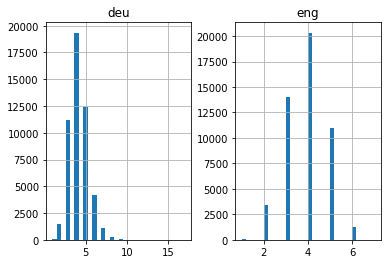

In [12]:
# empty lists 
eng_l = [] 
deu_l = [] 

# populate the lists with sentence lengths 
for i in deu_eng[:,0]: 
      eng_l.append(len(i.split())) 

for i in deu_eng[:,1]: 
      deu_l.append(len(i.split())) 

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
length_df.hist(bins = 30) 
plt.show()

the maximum length of the German sentences is 8 and that of the English phrases is 6.

### 3.3)-vectorize our text data 

by using Keras’s Tokenizer()

In [13]:
# function to build a tokenizer 
def tokenization(lines): 
      tokenizer = Tokenizer() 
      tokenizer.fit_on_texts(lines) 
      return tokenizer

# prepare english tokenizer 
eng_tokenizer = tokenization(deu_eng[:, 0]) 
eng_vocab_size = len(eng_tokenizer.word_index) + 1 
eng_length = 8 

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6352


In [14]:
# prepare Deutch tokenizer 
deu_tokenizer = tokenization(deu_eng[:, 1]) 
deu_vocab_size = len(deu_tokenizer.word_index) + 1 
deu_length = 8 
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10678


There is difference in amount of words in two languages.We need to encode sequence

### 3.4)-encode and pad sequences 

In [0]:
def encode_sequences(tokenizer, length, lines):          
         # integer encode sequences          
         seq = tokenizer.texts_to_sequences(lines)          
         # pad sequences with 0 values          
         seq = pad_sequences(seq, maxlen=length, padding='post')           
         return seq

# 4)-Model Building

### 4.1)- Train-test Split

80%-20%

In [0]:
from sklearn.model_selection import train_test_split 

# split data into train and test set 
train,test= train_test_split(deu_eng,test_size=0.2,random_state= 12)

### 4.2)- Defining input and target
We will encode English sentences as the input sequences and German sentences as the target sequences

In [17]:
# english version
train[:, 0]

array(['i have some bad news', 'spare me the details',
       'do you know my husband', ..., 'my bag was stolen',
       'tom works long hours', 'i like tom a lot'], dtype='<U537')

In [18]:
# english version
train[:, 1]

array(['ich habe schlechte nachrichten', 'erspare mir die einzelheiten',
       'kennst du meinen mann', ..., 'meine tasche wurde gestohlen',
       'tom hat eine lange arbeitszeit',
       'tom ist mir unglaublich sympathisch'], dtype='<U537')

In [0]:
# prepare training data 
trainX = encode_sequences(eng_tokenizer, deu_length, train[:, 0]) 
trainY = encode_sequences(deu_tokenizer, eng_length, train[:, 1]) 

# prepare validation data 
testX = encode_sequences(eng_tokenizer, deu_length, test[:, 0]) 
testY = encode_sequences(deu_tokenizer, eng_length, test[:, 1])

In [20]:
print(trainX[:5])

[[   2   19  143  135  481    0    0    0]
 [2670    9    8 2312    0    0    0    0]
 [  11    3   33   16  780    0    0    0]
 [  27  110   26   19    0    0    0    0]
 [  23    5  200  442    0    0    0    0]]


In [21]:
print(trainY[:5])

[[   1   14  604 1274    0    0    0    0]
 [9062   15   17 3411    0    0    0    0]
 [ 556    8  139  185    0    0    0    0]
 [  22   10    4    0    0    0    0    0]
 [   5    3   24 1429  393    0    0    0]]


In [22]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(40000, 8)
(40000, 8)
(10000, 8)
(10000, 8)


### 4.3)- build NMT model

In [23]:
eng_length

8

In [24]:
deu_length

8

In [0]:
 def build_model(in_vocab,out_vocab, in_timesteps,out_timesteps,n):   
      model = Sequential() 
      model.add(Embedding(in_vocab, n, input_length=in_timesteps,   
      mask_zero=True)) 
      model.add(LSTM(n)) 
      model.add(RepeatVector(out_timesteps)) 
      model.add(LSTM(n, return_sequences=True))  
      model.add(Dense(out_vocab, activation='softmax')) 
      return model

In [26]:
# model compilation (with 512 hidden units)
model = build_model(eng_vocab_size,deu_vocab_size, eng_length, deu_length, 512)

rms = optimizers.RMSprop(lr=0.001) 
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 512)            3252224   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 8, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 8, 10678)          5477814   
Total params: 12,928,438
Trainable params: 12,928,438
Non-trainable params: 0
_________________________________________________________________


In [28]:
filename = 'model_translate.h1' 

# set checkpoint
checkpoint = ModelCheckpoint(filename, monitor='val_loss',  
                             verbose=1, save_best_only=True, 
                             mode='min') 


# train model 
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
                    epochs=30, batch_size=512, validation_split = 0.2, 
                    callbacks=[checkpoint], verbose=1)


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 12s 390us/step - loss: 4.0179 - val_loss: 3.3885

Epoch 00001: val_loss improved from inf to 3.38848, saving model to model_translate.h1
Epoch 2/30
32000/32000 [==============================] - 10s 307us/step - loss: 3.2479 - val_loss: 3.2511

Epoch 00002: val_loss improved from 3.38848 to 3.25112, saving model to model_translate.h1
Epoch 3/30
32000/32000 [==============================] - 10s 311us/step - loss: 3.0295 - val_loss: 3.0428

Epoch 00003: val_loss improved from 3.25112 to 3.04282, saving model to model_translate.h1
Epoch 4/30
32000/32000 [==============================] - 10s 314us/step - loss: 2.8766 - val_loss: 2.9537

Epoch 00004: val_loss improved from 3.04282 to 2.95367, saving model to model_translate.h1
Epoch 5/30
32000/32000 [==============================] - 10s 316us/step - loss: 2.7599 - val_loss: 2.8474

Epoch 00005: val_loss improved from 2.95367 to 2.8

# 5)-Plotting results

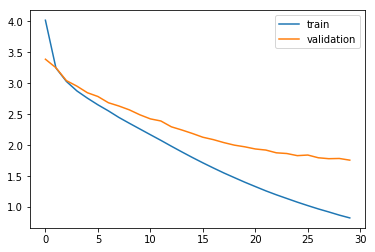

In [29]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['train','validation']) 
plt.show()

As you can see in the above plot, the validation loss stopped decreasing after 25 epochs. It did improve but not very significant.

# 6)-Make Predictions

In [0]:
model = load_model('model_translate.h1') 

preds = model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))

These predictions are sequences of integers. We need to convert these integers to their corresponding words.

### 6.1)- Convert integers to words

In [0]:
def get_word(n, tokenizer):  
      for word, index in tokenizer.word_index.items():                       
          if index == n: 
              return word 
      return None

### 6.2)-Convert predictions into text (German)

In [0]:
preds_text = [] 
for i in preds:        
       temp = []        
       for j in range(len(i)):             
            t = get_word(i[j], deu_tokenizer)             
            if j > 0:                 
                if (t==get_word(i[j-1],deu_tokenizer))or(t== None):                       
                     temp.append('')                 
                else:                      
                     temp.append(t)             
            else:                    
                if(t == None):                                   
                     temp.append('')                    
                else:                           
                     temp.append(t)        
       preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [37]:
# 1st 15 rows
pred_df.head(15)

,actual,predicted
0,er wollte reich sein,er wollte reich sein
1,ich liebe tom,ich liebe tom
2,lasst uns nach hause gehen,lass uns nach hause gehen
3,ich fahre für mein leben gern,ich liebe gern
4,das ist mein wörterbuch,das ist mein wörterbuch
5,hallo tom guten morgen,hallo tom
6,warum ist sie so beliebt,warum ist so
7,ich zeige euch mein zimmer,ich zeige dir mein zimmer
8,hat tom verschlafen,hat tom gewählt
9,leiste nur weiterhin so gute arbeit,mach sie auf


In [38]:
# print 15 rows randomly 
pred_df.sample(15)

,actual,predicted
7881,gib tom seine schlüssel,gib tom seine schlüssel
4549,stecke deine nase nicht in fremde angelegenheiten,kümmere dich deine eigenen angelegenheiten
7639,erzähl mir von tom,sag mir tom
8730,gefällt dir das piano,gefällt dir diese piano
3392,meine unterhose ist nass,meine schwester war verärgert
6503,tom war wirklich verärgert,tom war wirklich wütend
599,ich bin schlecht im französischen,ich bin nicht japanisch
2153,wem wirst du glauben,wen kannst du helfen
5714,haben sie es eilig,bist du ein zu
5612,mach jetzt deine hausaufgaben,mach eure ihre
